In [1]:
import os
import pygmt
import numpy as np
import xesmf as xe
import pandas as pd
import xarray as xr

from xarray import DataArray
from scipy.ndimage import gaussian_filter
from numpy import deg2rad, sin, cos, meshgrid, gradient

%config InlineBackend.figure_formats = ['svg']

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
timeclim = 0
curve = 'foster'

Get biomod ensemble data and environmental data

In [3]:
def regridding1(carbdata):
    ds_in = xr.DataArray(
        dims=["latitude", "longitude"],
        coords={"latitude": np.arange(-90,90.05,0.05), "longitude": np.arange(-180,180.05,0.05)},
    )
    ds_out = xe.util.grid_2d(-180.0, 180.0, 0.1, -90.0, 90.0, 0.1)
    regrid = xe.Regridder(ds_in, ds_out, 'nearest_s2d', periodic=True, weights='data/nearest_s2d_gridder_res1.nc')
    return regrid(carbdata)

def regridding2(ds):
    ds_out = xe.util.grid_2d(-180.0, 180.0, 0.25, -90.0, 90.0, 0.25)
    regrid = xe.Regridder(ds, ds_out, 'nearest_s2d', periodic=True, weights='data/nearest_s2d_gridder_res2.nc')
    return regrid(ds)

def getData(timeclim, CO2curve='smooth'):
    abiotic = xr.open_dataset('env_var/enviVar'+str(timeclim)+'Ma_res1_'+CO2curve+'.nc')
    continent = abiotic.flood.fillna(10)
    continent = continent.where(continent>4)
    abiotic['elevation'] = abiotic.bathy.copy()
    shelf = xr.open_dataset('data/shelfs/'+str(timeclim)+'Ma.nc')
    shelf2 = regridding1(shelf)
    shelf.close()
    abiotic['shelf'] = (('latitude', 'longitude'), shelf2.flood.values)
    ensemble = xr.open_dataset('photozoan.res2/proj_'+str(timeclim)+'Ma/proj_'+str(timeclim)+'Ma_photozoan.res2_ensemble.tif')
    return abiotic, ensemble, continent

def earth_radius(lat):
    a = 6378137
    b = 6356752.3142
    e2 = 1 - (b**2/a**2)
    lat = deg2rad(lat)
    lat_gc = np.arctan( (1-e2)*np.tan(lat) )
    r = (
        (a * (1 - e2)**0.5) 
         / (1 - (e2 * np.cos(lat_gc)**2))**0.5 
        )
    return r

def area_grid(lat, lon):
    xlon, ylat = meshgrid(lon, lat)
    R = earth_radius(ylat)
    dlat = deg2rad(gradient(ylat, axis=0))
    dlon = deg2rad(gradient(xlon, axis=1))
    dy = dlat * R
    dx = dlon * R * cos(deg2rad(ylat))
    area = dy * dx
    xda = DataArray(
        area,
        dims=["latitude", "longitude"],
        coords={"latitude": lat, "longitude": lon},
        attrs={
            "long_name": "area_per_pixel",
            "description": "area per pixel",
            "units": "m^2",
        },
    )
    return xda

abiotic, ensemble, continent = getData(timeclim, CO2curve=curve)
flooddata = regridding2(abiotic)
da_area = area_grid(abiotic['latitude'], abiotic['longitude'])

FileNotFoundError: [Errno 2] No such file or directory: '/Users/jono/Library/CloudStorage/OneDrive-TheUniversityofSydney(Staff)/paleoReef/tristanCode/sdm/env_var/enviVar86Ma_res1_foster.nc'

In [ ]:
da_area.sum()

<xarray.DataArray ()>
array(5.10070281e+14)

Create a netcdf dataset from ensemble projection

In [ ]:
dataType = ['e_mean','cv','e_median','ca','wmean','ciInf', 'ciSup']

dataName = ['Mean', 'Coefficient of variation', 'Median', 
            'Committee averaging score', 'Weighted mean', 
            'Confidence interval (lower)', 'Confidence interval (upper)']
     
k = -1
for k in range(len(dataType)):
    nda = xr.DataArray(
                    ensemble.isel(band=k).band_data.values,
                    dims=["latitude", "longitude"],
                    coords={"latitude": ensemble.y.values, "longitude": ensemble.x.values},
                )

    if k == 0:
        dataEM = nda.to_dataset(name=dataType[k])

    tmp = nda.fillna(0).values
    dataEM[dataType[k]] = (('latitude', 'longitude'), gaussian_filter(tmp,1))
    
dataEM['flood'] = (('latitude', 'longitude'), np.flipud(flooddata.flood.values))
dataEMFlood = dataEM.where(dataEM.flood==1)

Get fossil record

In [ ]:
geodata = pd.read_csv('data/PARED_paleomap_time.csv').dropna()
geodata = geodata.loc[geodata['time'] == timeclim].reset_index(drop=True)
paredLat = geodata['lat'].values
paredLon = geodata['lon'].values

keepIds = []
for k in range(len(paredLat)):
    val = abiotic.flood.sel(longitude=paredLon[k],latitude=paredLat[k],method='nearest').values
    if val == 1:
        keepIds.append(k)

Plot ensemble result

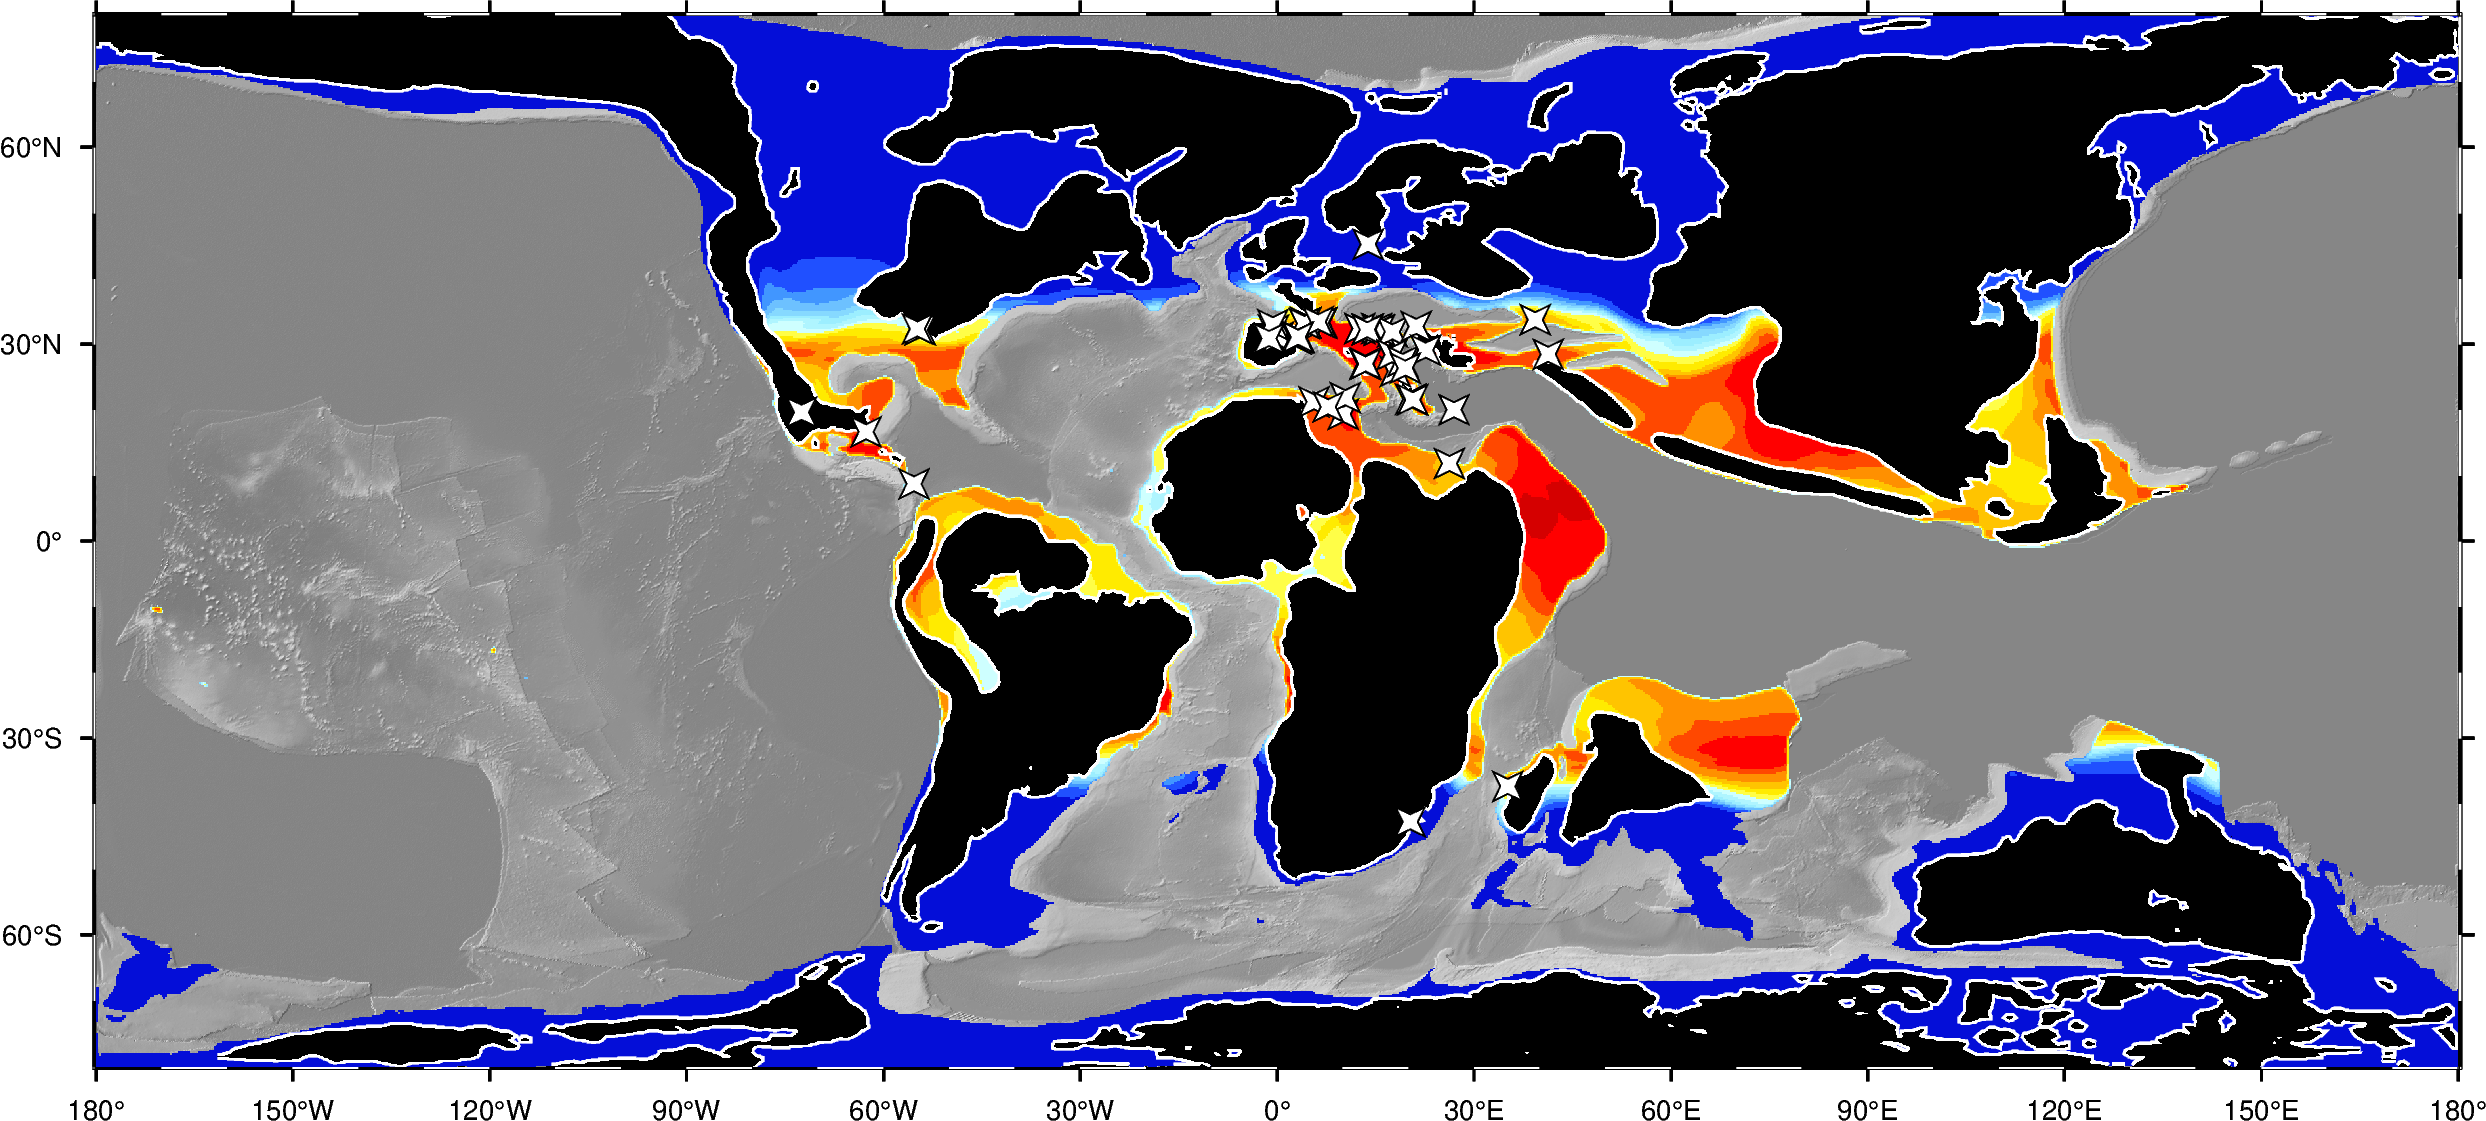

In [ ]:
region = [-180,180,-80,80]#'d'

fig = pygmt.Figure()
pygmt.config(
    MAP_FRAME_WIDTH="0.5p",
    MAP_FRAME_TYPE="fancy",
)
font = "4p,Helvetica-Bold"

with pygmt.config(FONT='4p,Helvetica,black'):
    pygmt.makecpt(cmap="gray", series=[-15000, 4000])
    fig.basemap(region=region, projection="Q12c", frame='af')
    fig.grdimage(abiotic.elevation, shading=True, frame=False) 
    pygmt.makecpt(cmap="panoply", series=[0, 1000], reverse=False)
#     fig.grdimage(dataEM.wmean.where(dataEM.wmean), shading=False, 
#                  nan_transparent=True, frame=False, transparency=70) 
    fig.grdimage(dataEMFlood.wmean.where(dataEMFlood.wmean), shading=False, 
                 nan_transparent=True, frame=False) 
    
    fig.grdcontour(interval=1,grid=abiotic.shelf,limit=[1.9, 2],pen="0.9p,white")
    pygmt.makecpt(cmap="black", series=[8, 10])
    fig.grdimage(continent, shading=True, nan_transparent=True, frame=False)
    if len(paredLon)>0:
        fig.plot(x=paredLon, y=paredLat, style="kstar4/0.15c", fill="white", pen="0.2p,black")
    
fig.show(dpi=500, width=1000)

Add ensemble models to full dataset

In [ ]:
regrid = xe.Regridder(dataEM, abiotic, 'bilinear', periodic=True, weights='data/bilinear_gridder_reef.nc') 
ensembleReef = regrid(dataEM)
abiotic['area'] = da_area.copy()*1.e-6
abiotic['wMean'] = ensembleReef.wmean.copy()/1000.
abiotic['Mean'] = ensembleReef.e_mean.copy()/1000.
abiotic['CV'] = ensembleReef.cv.copy()/1000.
abiotic['Median'] = ensembleReef.e_median.copy()/1000.
abiotic['CA'] = ensembleReef.ca.copy()/1000.

/Users/galois/conda/anaconda3/envs/reefmodel/lib/python3.11/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


Global evaluation of factory distribution compared to shelf area

In [ ]:
shelfdata = abiotic.where(abiotic.flood==1) 
sumShelf = shelfdata.area.sum()

shelfPercTot = np.round(sumShelf.values/abiotic['area'].sum().values*100,2)
# print('Percentage of shelf area vs Earth area', shelfPercTot)

ocean = abiotic.where(abiotic.flood<10).area.sum().values
shelfPercOcean = np.round(sumShelf.values/ocean*100,2)
# print('Percentage of shelf area vs Ocean area',shelfPercOcean)

wmean_thres = 0.
sumCarb = (shelfdata.area*shelfdata.where(shelfdata.wMean>wmean_thres).wMean).sum()
factoryShelf = np.round(sumCarb.values/sumShelf.values*100,2)
# print('Percentage of shelf covered by Photozoan factory vs total shelf area',factoryShelf)

Tropics evalution of factory distribution compared to shelf area

In [ ]:
shelftropicdata = abiotic.where((abiotic.flood==1)&(abiotic.latitude<45)*(abiotic.latitude>-45)) 
sumTropicShelf = shelftropicdata.area.sum()
tshelfPercTot = np.round(sumTropicShelf.values/abiotic['area'].sum().values*100,2)
# print('Percentage of tropic shelf area vs Earth area',tshelfPercTot)

tshelf_shelfTot = np.round(sumTropicShelf.values/sumShelf.values*100,2)
# print('Percentage of tropic shelf area vs total shelf area',tshelf_shelfTot)

sumTropicCarb = (shelftropicdata.area*shelfdata.where(shelftropicdata.wMean>wmean_thres).wMean).sum()
tropicfactoryShelf = np.round(sumTropicCarb.values/sumTropicShelf.values*100,2)
# print('Percentage of Tropic shelf covered by carbonate platform',tropicfactoryShelf)

Store percentages in a pandas dataframe

In [ ]:
colName = ['Time (Ma)','Shelf Area vs Earth Area (%)','Shelf Area vs Ocean Area (%)',
           'Photozoan Area vs Shelf Area (%)', 'Tropic Shelf Area vs Earth Area (%)',
           'Tropic Shelf Area vs Shelf Area (%)', 'Tropic Photozoan Area vs Tropic Shelf Area (%)'
          ]
valTime = [timeclim,shelfPercTot,shelfPercOcean,factoryShelf,tshelfPercTot,tshelf_shelfTot,tropicfactoryShelf]
  
percfile = 'data/percentPhotozoan_'+curve+'.csv'
if os.path.isfile(percfile):
    tmp = pd.read_csv(percfile)
    tmp.loc[len(tmp.index)] = valTime
    tmp = tmp.drop_duplicates().sort_values('Time (Ma)') 
    tmp.to_csv(percfile,index=False)
else:
    df = pd.DataFrame(columns=colName)
    df.loc[len(df.index)] = valTime
    df.to_csv(percfile,index=False)

In [ ]:
tmp

Time (Ma)  Shelf Area vs Earth Area (%)  Shelf Area vs Ocean Area (%)   
0         0.0                         10.12                         14.06  \
1         4.0                          8.63                         12.22   
2        10.0                          8.72                         12.42   
3        14.0                          8.75                         12.45   
4        19.0                          9.64                         13.65   
5        25.0                          7.69                         11.18   
6        31.0                          8.71                         12.57   
7        35.0                          8.94                         12.91   
8        39.0                          9.94                         14.30   
9        44.0                         10.92                         15.41   
10       52.0                         14.40                         19.44   
11       55.0                         12.11                         16.79   
12       60.0                         12.11                         16.79   
13       66.0                         13.70                         18.58   
14       69.0                         14.80                         19.91   
15       75.0                         19.08                         24.01   
16       80.0                         19.08                         24.01   
53       86.0                         16.66                         21.49   
17       91.0                         16.44                         21.26   
18       97.0                         14.61                         19.43   
19      102.0                         12.90                         17.64   
20      107.0                         12.90                         17.64   
21      111.0                         12.90                         17.64   
22      115.0                         15.74                         20.89   
23      121.0                         15.74                         20.89   
24      127.0                         11.91                         16.53   
25      131.0                          9.98                         14.20   
26      136.0                          9.45                         13.58   
27      142.0                         11.06                         15.61   
28      145.0                         10.73                         15.09   
29      148.0                         10.73                         15.09   
30      154.0                         11.27                         15.66   
31      160.0                         14.58                         19.42   
32      164.0                         13.52                         18.25   
33      168.0                         11.75                         16.27   
34      172.0                         11.75                         16.27   
35      178.0                          8.44                         12.25   
36      186.0                          9.08                         13.03   
37      190.0                         10.18                         14.26   
38      196.0                         10.18                         14.26   
39      201.0                         12.87                         17.37   
40      204.0                         12.15                         16.61   
41      213.0                         14.02                         18.75   
42      217.0                         14.02                         18.75   
43      222.0                         14.02                         18.75   
44      227.0                         12.96                         17.40   
45      232.0                         12.96                         17.40   
46      233.0                         12.96                         17.40   
47      239.0                         13.34                         17.83   
48      244.0                         13.69                         18.25   
49      252.0                         11.98                         16.15   


Visualise tropics distribution

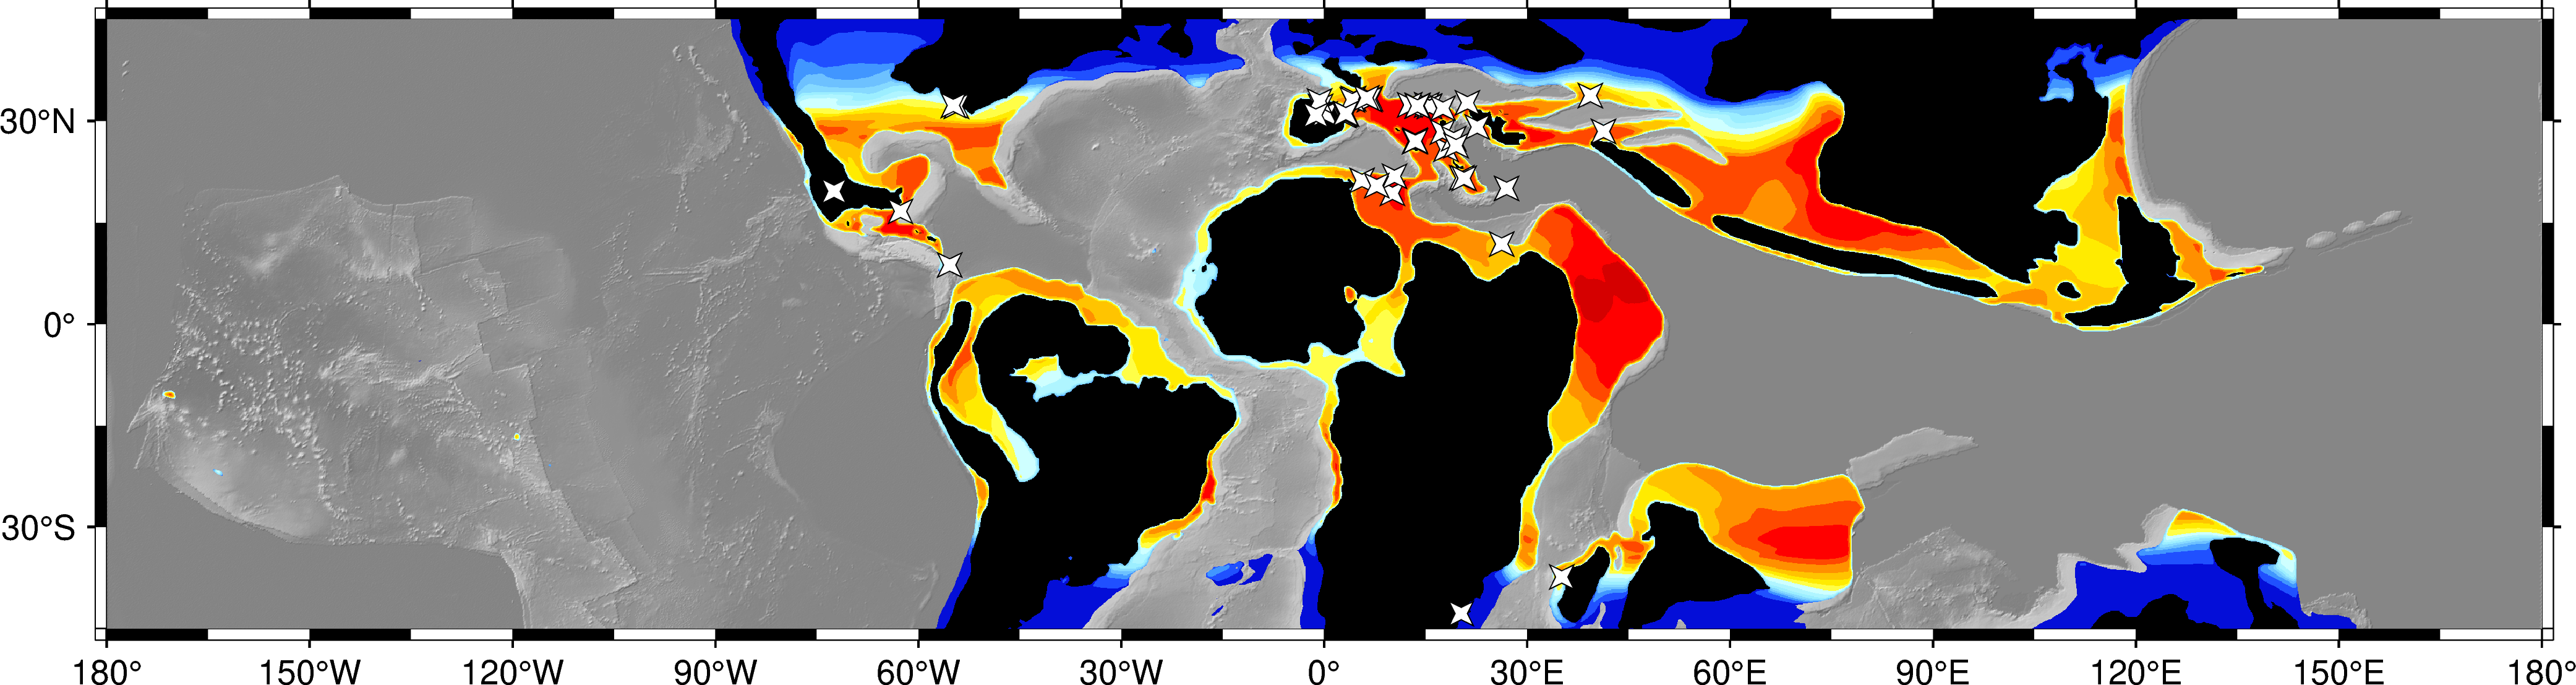

In [ ]:
continent = abiotic.flood.fillna(10)
continent = continent.where(continent>4)

wmean_thres2 = 0.2
reef = shelfdata.where(shelfdata.wMean>wmean_thres).wMean

region = [-180, 180, -45, 45]
fig = pygmt.Figure()
with pygmt.config(FONT='8p,Helvetica,black'):
    fig.basemap(region=region, 
                projection="Q20c", #"J-180/20c", #projection='M15c', 
                frame='a30fg')
    
    pygmt.makecpt(cmap="gray", series=[-15000, 4000])
    fig.grdimage(abiotic.bathy, shading=True, frame=False,transparency=0) 
    pygmt.makecpt(cmap="panoply", reverse=False, series=[0, 1])
#     fig.grdimage(grid=abiotic.wMean,transparency=90,nan_transparent=True, frame=False)
    fig.grdimage(grid=shelfdata.wMean,transparency=0,nan_transparent=True, frame=False)
    pygmt.makecpt(cmap="black", series=[8, 10])
    fig.grdimage(continent, shading=True, nan_transparent=True, frame=False)
    if len(paredLon)>0:
        fig.plot(x=paredLon, y=paredLat, style="kstar4/0.2c", fill="white", pen="0.2p,black")
    
fig.show(dpi=500, width=1000)

In [ ]:
reefArea = (shelfdata.area*reef).copy()
latbins = np.linspace(-90,90,181,endpoint=True)
lonbins = np.linspace(-180,180,361,endpoint=True)
tropicdata = shelfdata.where((shelfdata.latitude<45)*(shelfdata.latitude>-45)) 
tropicReefArea = (tropicdata.area*tropicdata.wMean).copy()

divlon_mean2 = tropicReefArea.sum(dim='latitude')
divlat_mean2 = tropicReefArea.sum(dim='longitude')

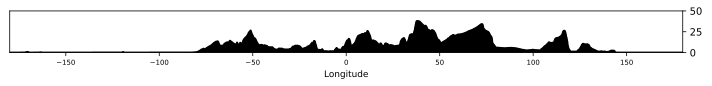

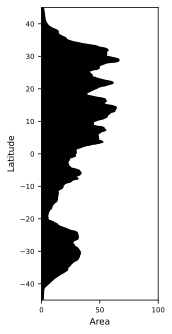

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 1.25),dpi=300)
ax1.plot(divlon_mean2.longitude.data, divlon_mean2.data/1000, alpha=1, lw=2, color="k")
ax1.fill_between(divlon_mean2.longitude.data, 0, 
                 divlon_mean2.data/1000, color='k',
                 alpha=1)
for label in (ax1.get_xticklabels() + ax1.get_yticklabels()):
    label.set_fontsize(7)
ax1.set_xlim(-180, 180)
ax1.set_ylim(0, 50)
# ax1.set_ylabel("Area", fontsize=9)
ax1.set_xlabel("Longitude", fontsize=9)
ax1.label_outer
ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right()
# plt.title('Distribution')

fig.tight_layout()
plt.savefig('figs/'+curve+'_trend_div_lon'+str(timeclim)+'.png',dpi=300)
plt.show()

fig, ax1 = plt.subplots(figsize=(2.5, 4.75),dpi=300)
ax1.plot(divlat_mean2.data/1000., divlat_mean2.latitude.data, alpha=1, lw=2, color="k")
ax1.fill_betweenx(divlat_mean2.latitude.data, 0, divlat_mean2.data/1000., 
                 color='k',
                 alpha=1)
for label in (ax1.get_xticklabels() + ax1.get_yticklabels()):
    label.set_fontsize(7)
ax1.set_ylim(-45, 45)
ax1.set_xlim(0, 100)
ax1.set_xlabel("Area", fontsize=9)
ax1.set_ylabel("Latitude", fontsize=9)
ax1.label_outer
# plt.title('Distribution')
# ax1.invert_xaxis()
fig.tight_layout()
plt.savefig('figs/'+curve+'_trend_div_lat'+str(timeclim)+'.png',dpi=300)
plt.show()